In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import sqlite3
from pathlib import Path
from lmfit.models import LinearModel
from lmfit import Parameters, minimize, report_fit
import statsmodels.formula.api as smf
from scipy import constants

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams["lines.linewidth"] = 0.5
mpl.rcParams["axes.linewidth"] = 0.5

mpl.rcParams.update({
    "xtick.major.width": 0.5,
    "ytick.major.width": 0.5,
    "xtick.minor.width": 0.5,
    "ytick.minor.width": 0.5,
})

# set font size
mpl.rcParams.update({'font.size': 7})

def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

In [2]:
# NMR data import (parameters from ODE fits)
all_fit_params = 'nmr_NTP_ode_fitparams.csv'
nmr_ntp = pd.read_csv(all_fit_params)
nmr_ntp = nmr_ntp[nmr_ntp['peak'] == 'peak8']
nmr_ntp['base'] = nmr_ntp['ntp'].str[0]
nmr_ntp['method'] = 'nmr'
nmr_ntp['lnkadd_err'] = nmr_ntp['k1_err'] / nmr_ntp['k1']
nmr_ntp = nmr_ntp[['lnkadd', 'lnkadd_err', '1/T', 'base', 'method']]
nmr_ntp.columns = ['log_kobs', 'log_kobs_err', 'inv_temp', 'base', 'method']

In [3]:
nerd_sqlite = '../../../Core_nerd_analysis/nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

In [4]:
# Load all fit parameters for round3_constrained modrate fits
fit_params_df = read_sql(
    """
    WITH run AS (
        SELECT
            r.id  AS fit_run_id,
            r.rg_id,
            mn.site,
            UPPER(mn.base) AS base
        FROM probe_tc_fit_runs r
        JOIN meta_nucleotides mn ON mn.id = r.nt_id
        WHERE r.fit_kind = 'round3_constrained'
          AND r.valtype  = 'modrate'
    )
    SELECT
        r.rg_id,
        r.site,
        r.base,
        MIN(pr.temperature) AS temperature,
        MAX(mc.disp_name)   AS disp_name,

        MAX(CASE WHEN p.param_name IN ('log_kobs','logkobs')
                 THEN p.param_numeric END) AS log_kobs,
        MAX(CASE WHEN p.param_name IN ('log_kdeg','logkdeg')
                 THEN p.param_numeric END) AS log_kdeg,
        MAX(CASE WHEN p.param_name IN ('log_kobs_err','logkobs_err')
                 THEN p.param_numeric END) AS log_kobs_err,
        MAX(CASE WHEN p.param_name IN ('log_kdeg_err','logkdeg_err')
                 THEN p.param_numeric END) AS log_kdeg_err,
        MAX(CASE WHEN p.param_name = 'diag:r2'
                 THEN p.param_numeric END) AS diag_r2

    FROM probe_tc_fit_params p
    JOIN run r              ON r.fit_run_id = p.fit_run_id
    JOIN probe_reactions pr ON pr.rg_id      = r.rg_id
    JOIN meta_constructs mc ON mc.id         = pr.construct_id

    GROUP BY r.fit_run_id, r.rg_id, r.site, r.base
    """
    )

# Preprocess k_vals to get k_add-like values
fit_params_df.loc[:, 'inv_temp'] = 1/(273.15 + fit_params_df['temperature'])
conc_DMS = 0.015852692  # in M, 1.5% v/v
# log_kobs in nerd is kappa for now, need to correct later
# new log_kobs below is K/K+1 kadd [P]_0
fit_params_df.loc[:, 'log_kobs'] = fit_params_df['log_kobs'] + fit_params_df['log_kdeg'] - np.log(conc_DMS) # adjust for 1.564 mM DMS
fit_params_df

,rg_id,site,base,temperature,disp_name,log_kobs,log_kdeg,log_kobs_err,log_kdeg_err,diag_r2,inv_temp
0,20,1,A,80.0,4U_wt,NaN,NaN,NaN,NaN,NaN,0.002832
1,20,2,G,80.0,4U_wt,NaN,NaN,NaN,NaN,NaN,0.002832
2,20,3,G,80.0,4U_wt,NaN,NaN,NaN,NaN,NaN,0.002832
3,20,4,U,80.0,4U_wt,NaN,NaN,NaN,NaN,NaN,0.002832
4,20,5,U,80.0,4U_wt,-31.793362,-4.606971,NaN,NaN,-2.300249e-11,0.002832
...,...,...,...,...,...,...,...,...,...,...,...
4718,130,263,C,23.0,p4p6_wt_nobc,-9.715564,-8.181574,0.234228,0.0,7.853063e-01,0.003377
4719,130,264,C,23.0,p4p6_wt_nobc,-10.890685,-8.181574,0.634883,0.0,3.318751e-01,0.003377
4720,130,265,A,23.0,p4p6_wt_nobc,-9.798570,-8.181574,0.165945,0.0,8.793265e-01,0.003377
4721,130,266,A,23.0,p4p6_wt_nobc,-9.714303,-8.181574,0.197353,0.0,8.374605e-01,0.003377


In [5]:
# Initialize empty dataframe to hold aggregated values
agg_values_df = pd.DataFrame(columns=['log_kobs', 'log_kobs_err', 'inv_temp', 'base', 'method'])

# Filter df to fourU data ('4U_') and between 60-85°C for sites of interest
fit_params_df = fit_params_df[(fit_params_df['disp_name'].str.contains('4U_')) & 
                              (fit_params_df['temperature'] > 59) & 
                              (fit_params_df['temperature'] < 85)]

# Manually define sites to aggregate
sites_dict = {'A': [7, 15, 16, 18, 22, 26, 29, 34, 35], 'C': [9, 25], 'G': [19, 31]}

# Aggregate data by base and construct
for base in ['A', 'G', 'C']:
    data = fit_params_df[fit_params_df['site'].isin(sites_dict[base])].copy()
    
    # Filter data greater than -8.5 (outlier)
    if (base == 'A') or (base == 'C'):    
        data = data[data['log_kobs'] > -8.5]

    # Aggregate by disp_name and inv_temp
    grouped = data.groupby(['disp_name', 'inv_temp'])['log_kobs'].agg(
        log_kobs='mean',
        log_kobs_err='sem'
    ).reset_index()

    grouped['base'] = base
    grouped['method'] = 'melted_agg'

    to_append = grouped[['log_kobs', 'log_kobs_err', 'inv_temp', 'base', 'method']].copy()
    
    agg_values_df = pd.concat([agg_values_df, to_append], ignore_index=True)

# aggregated by construct
agg_values_df

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_62243/2882740426.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  agg_values_df = pd.concat([agg_values_df, to_append], ignore_index=True)


,log_kobs,log_kobs_err,inv_temp,base,method
0,-2.450894,0.052331,0.002832,A,melted_agg
1,-2.983999,0.046289,0.002872,A,melted_agg
2,-2.944999,0.045990,0.002914,A,melted_agg
3,-3.862137,0.039780,0.003002,A,melted_agg
4,-3.019263,0.026227,0.002832,A,melted_agg
5,-3.540015,0.080938,0.002872,A,melted_agg
6,-3.513261,0.040461,0.002914,A,melted_agg
7,-3.791547,0.028097,0.002957,A,melted_agg
8,-3.850198,0.023458,0.003002,A,melted_agg
9,-5.686789,0.429176,0.002832,G,melted_agg


In [6]:
all_fits_kobs = pd.concat([nmr_ntp, agg_values_df], ignore_index=True).dropna()
all_fits_kobs_A = all_fits_kobs[all_fits_kobs['base'] == 'A']
all_fits_kobs_C = all_fits_kobs[all_fits_kobs['base'] == 'C']
all_fits_kobs_G = all_fits_kobs[all_fits_kobs['base'] == 'G']

all_fits_kobs_A

,log_kobs,log_kobs_err,inv_temp,base,method
0,-7.064601,0.117700,0.003411,A,nmr
1,-5.756667,0.034213,0.003224,A,nmr
2,-5.557570,0.047333,0.003224,A,nmr
3,-5.345155,0.147587,0.003173,A,nmr
4,-5.471566,0.120953,0.003173,A,nmr
5,-4.543482,0.126005,0.003114,A,nmr
17,-2.450894,0.052331,0.002832,A,melted_agg
18,-2.983999,0.046289,0.002872,A,melted_agg
19,-2.944999,0.045990,0.002914,A,melted_agg
20,-3.862137,0.039780,0.003002,A,melted_agg


In [7]:
# linear fit using lmfit

def fit_linear_model(data):
    model = LinearModel()
    params = model.make_params(slope=-7800, intercept=20)
    weights = 1 / data['log_kobs_err']**2
    result = model.fit(data['log_kobs'], params, x=data['inv_temp'], weights=weights)

    # calculate r2 (weighted)
    y = data['log_kobs'].values
    x = data['inv_temp'].values
    w = weights.values 
    y_fit = result.eval(x=x)
    y_mean = np.average(y, weights=w)
    ss_tot = np.sum(w * (y - y_mean)**2)
    ss_res = np.sum(w * (y - y_fit)**2)
    r2 = 1 - ss_res / ss_tot

    # return n_data, slope, slope_stdev, intercept, intercept_stdev
    num_data = result.ndata
    m = result.params['slope'].value
    m_stdev = result.params['slope'].stderr / np.sqrt(num_data)
    b = result.params['intercept'].value
    b_stdev = result.params['intercept'].stderr / np.sqrt(num_data)

    return num_data, m, m_stdev, b, b_stdev, result, r2

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Parameters, minimize, report_fit

def plot_individual_linear_fits(all_fits_kobs, plot_filename = None):
    # Prepare the two datasets
    data_1 = all_fits_kobs[all_fits_kobs['method'] == 'melted_agg']
    data_2 = all_fits_kobs[all_fits_kobs['method'] == 'nmr']

    x_vals = [data_1['inv_temp'].values, data_2['inv_temp'].values]
    y_vals = [data_1['log_kobs'].values, data_2['log_kobs'].values]
    weights = [1 / data_1['log_kobs_err'].values**2, 1 / data_2['log_kobs_err'].values**2]

    # Individual linear model: separate slopes and intercepts
    def linear_dataset(params, i, x):
        slope = params[f'slope_{i+1}']
        intercept = params[f'intercept_{i+1}']
        return slope * x + intercept

    def objective(params, x_vals, y_vals, weights):
        resid = []
        for i in range(len(y_vals)):
            model_y = linear_dataset(params, i, x_vals[i])
            resid.append((y_vals[i] - model_y) * np.sqrt(weights[i]))
        return np.concatenate(resid)

    # Initialize parameters
    fit_params = Parameters()
    for i in range(2):  # two datasets
        fit_params.add(f'slope_{i+1}', value=-8000)
        fit_params.add(f'intercept_{i+1}', value=10.0)

    # Run minimization
    out = minimize(objective, fit_params, args=(x_vals, y_vals, weights))
    report_fit(out.params)

    # calculate r2 for each dataset
    r2_vals = []
    for i in range(2):
        y_mean = np.average(y_vals[i], weights=weights[i])
        ss_tot = np.sum(weights[i] * (y_vals[i] - y_mean)**2)
        ss_res = np.sum(weights[i] * (y_vals[i] - linear_dataset(out.params, i, x_vals[i]))**2)
        r2 = 1 - ss_res / ss_tot
        r2_vals.append(r2)

    # Plotting
    fig, ax = plt.subplots(figsize=(2, 2))
    colors = ['darkred', 'black']
    labels = [f'PRIME-DMS (R2 {r2_vals[0]:.2f})', f'NMR (R2 {r2_vals[1]:.2f})']

    for i in range(2):
        x = x_vals[i]
        y = y_vals[i]
        w = weights[i]
        y_fit = linear_dataset(out.params, i, x)

        ax.errorbar(x, y, yerr=1/np.sqrt(w), fmt='o', markersize = 3, color=colors[i], label=labels[i])
        ax.plot(np.sort(x), linear_dataset(out.params, i, np.sort(x)), '-', color=colors[i])

    formatter = FuncFormatter(thousands)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_ylabel(r'$\ln(k_{add})$')
    ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
    ax.legend(frameon = False)
    plt.tight_layout()

    if plot_filename:
        plt.savefig(plot_filename)

    plt.show()

    return out, r2_vals

In [18]:
def extract_arrhenius_params(out):
    """Extract Arrhenius parameters from lmfit output."""

    R_kcal_per_mol_K = constants.R / constants.calorie / 1000  # kcal/(mol·K)

    results = []
    for i, label in enumerate(['melted_agg', 'nmr']):
        slope = out.params[f'slope_{i+1}'].value
        slope_err = out.params[f'slope_{i+1}'].stderr
        intercept = out.params[f'intercept_{i+1}'].value
        intercept_err = out.params[f'intercept_{i+1}'].stderr

        ea = -slope * R_kcal_per_mol_K
        ea_err = slope_err * R_kcal_per_mol_K if slope_err is not None else None

        lnA = intercept
        lnA_err = intercept_err

        results.append({
            'group': label,
            'ea': ea,
            'ea_err': ea_err,
            'lnA': lnA,
            'lnA_err': lnA_err
        })

    df = pd.DataFrame(results)
    return df

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


[[Variables]]
    slope_1:     -5843.64111 +/- 882.345595 (15.10%) (init = -8000)
    intercept_1:  13.6508169 +/- 2.58332029 (18.92%) (init = 10)
    slope_2:     -7827.40528 +/- 2690.08278 (34.37%) (init = -8000)
    intercept_2:  19.5548070 +/- 8.67566383 (44.37%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope_2, intercept_2) = -0.9999
    C(slope_1, intercept_1) = -0.9997


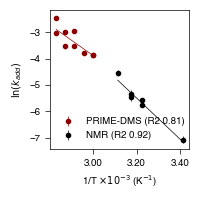

<lmfit.minimizer.MinimizerResult object at 0x16b89a060> [np.float64(0.8106032150832854), np.float64(0.9184597564710726)]


In [19]:
fourU_A_lmfit, r2 = plot_individual_linear_fits(all_fits_kobs_A, 'A_linear_fit_individual.pdf')
print(fourU_A_lmfit, r2)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


[[Variables]]
    slope_1:     -5053.74675 +/- 1367.14407 (27.05%) (init = -8000)
    intercept_1:  11.5580377 +/- 4.03032176 (34.87%) (init = 10)
    slope_2:     -11189.8226 +/- 774.820327 (6.92%) (init = -8000)
    intercept_2:  30.6783064 +/- 2.52934192 (8.24%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope_1, intercept_1) = -0.9997
    C(slope_2, intercept_2) = -0.9995


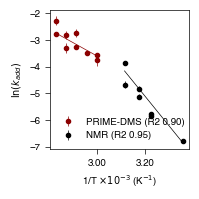

In [20]:
fourU_C_lmfit, r2 = plot_individual_linear_fits(all_fits_kobs_C, 'C_linear_fit_individual.pdf')

[[Variables]]
    slope_1:     -8141.62263 +/- 8519.04609 (104.64%) (init = -8000)
    intercept_1:  16.4806232 +/- 24.7931837 (150.44%) (init = 10)
    slope_2:     -13923.6226 +/- 2001.66567 (14.38%) (init = -8000)
    intercept_2:  39.9668450 +/- 6.53684892 (16.36%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope_2, intercept_2) = -1.0000
    C(slope_1, intercept_1) = -0.9999


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


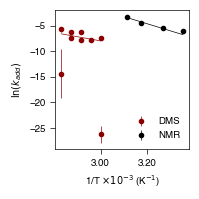

In [12]:
fourU_G_lmfit, r2 = plot_individual_linear_fits(all_fits_kobs_G, 'G_linear_fit_individual.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


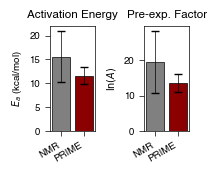

In [26]:
### Bar plot of Arrhenius parameters

# Prepare data
dfA_arrhenius = extract_arrhenius_params(fourU_A_lmfit)
dfC_arrhenius = extract_arrhenius_params(fourU_C_lmfit)
dfA_arrhenius['group'] = dfA_arrhenius['group'].replace({'melted_agg': 'melted_agg_A', 'nmr': 'nmr_A'})
dfC_arrhenius['group'] = dfC_arrhenius['group'].replace({'melted_agg': 'melted_agg_C', 'nmr': 'nmr_C'})
df_arrhenius = pd.concat([dfA_arrhenius, dfC_arrhenius], ignore_index=True)


# Map groups to display names and colors
group_labels = {
    'nmr_A': 'NMR',
    'melted_agg_A': 'PRIME',
    'nmr_C': 'NMR',
    'melted_agg_C': 'PRIME',
    '4U_a8c': 'DMS (4U A8C)'
}
colors = {
    'nmr_A': 'gray',
    'melted_agg_A': '#8B0000',   # dark red
    'nmr_C': 'gray',
    'melted_agg_C': '#8B0000',   # dark red
}

# Set 'group' as the index for easier access
df_arrhenius = df_arrhenius.set_index('group')

# Define group order for plotting
groups = ['nmr_A', 'melted_agg_A']
x = range(len(groups))

fig, axs = plt.subplots(1, 2, figsize=(2, 1.75), sharey=False)

# Ea bar plot
axs[0].bar(
    x,
    df_arrhenius.loc[groups, 'ea'],
    yerr=df_arrhenius.loc[groups, 'ea_err'],
    capsize=3,
    edgecolor='black',
    linewidth=0.5,
    color=[colors[g] for g in groups]
)
axs[0].set_title(r'Activation Energy')
axs[0].set_ylabel(r'$E_a$ (kcal/mol)')
axs[0].set_xticks(x)
axs[0].set_xticklabels([group_labels[g] for g in groups], rotation=30, ha='right')

# lnA bar plot
axs[1].bar(
    x,
    df_arrhenius.loc[groups, 'lnA'],
    yerr=df_arrhenius.loc[groups, 'lnA_err'],
    capsize=3,
    edgecolor='black',
    linewidth=0.5,
    color=[colors[g] for g in groups]
)
axs[1].set_title(r'Pre-exp. Factor')
axs[1].set_ylabel(r'$\ln(A)$')
axs[1].set_xticks(x)
axs[1].set_xticklabels([group_labels[g] for g in groups], rotation=30, ha='right')

plt.tight_layout()
plt.savefig('A_arrhenius_barplot.pdf')
plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


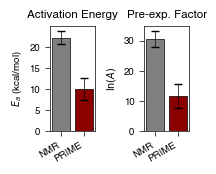

In [25]:

# Define group order for plotting
groups = ['nmr_C', 'melted_agg_C']
x = range(len(groups))

fig, axs = plt.subplots(1, 2, figsize=(2, 1.75), sharey=False)

# Ea bar plot
axs[0].bar(
    x,
    df_arrhenius.loc[groups, 'ea'],
    yerr=df_arrhenius.loc[groups, 'ea_err'],
    capsize=3,
    edgecolor='black',
    linewidth=0.5,
    color=[colors[g] for g in groups]
)
axs[0].set_title(r'Activation Energy')
axs[0].set_ylabel(r'$E_a$ (kcal/mol)')
axs[0].set_xticks(x)
axs[0].set_xticklabels([group_labels[g] for g in groups], rotation=30, ha='right')

# lnA bar plot
axs[1].bar(
    x,
    df_arrhenius.loc[groups, 'lnA'],
    yerr=df_arrhenius.loc[groups, 'lnA_err'],
    capsize=3,
    edgecolor='black',
    linewidth=0.5,
    color=[colors[g] for g in groups]
)
axs[1].set_title(r'Pre-exp. Factor')
axs[1].set_ylabel(r'$\ln(A)$')
axs[1].set_xticks(x)
axs[1].set_xticklabels([group_labels[g] for g in groups], rotation=30, ha='right')

plt.tight_layout()
plt.savefig('C_arrhenius_barplot.pdf')
plt.show()